In [1]:
import pandas as pd
import numpy as np
import scprep, scanpy
import networkx as nx
import sys
import phate
import omnipath
import sklearn
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pylab import *

/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
conv = {'Astro': 'Astrocyte', 'Endo': 'Endothelial Cell', 'Micro': 'Microglia',
 'Oligo': 'Oligodendrocyte', 'OPC': 'Oligodendrocyte Precursor Cell',
        'Ndnf': 'GABA-ergic Neuron', 'Pvalb': 'GABA-ergic Neuron',
       'Sst': 'GABA-ergic Neuron', 'Vip': 'GABA-ergic Neuron', 'Igtp/Smad3': 'GABA-ergic Neuron',
       'L2/3': 'Glutamatergic Neuron', 'L4_Ctxn3/Scnn1a': 'Glutamatergic Neuron', 'L5a':'Glutamatergic Neuron',
       'L5b':'Glutamatergic Neuron', 'L6a':'Glutamatergic Neuron', 'L6b':'Glutamatergic Neuron'}

In [3]:
cell_types = np.unique(list(conv.values()))

In [4]:
spatial_metadata = pd.read_csv('data/seqFISH_visual_cortex_metadata.csv', index_col=0)
spatial_data = pd.read_csv('data/seqFISH_visual_cortex_data.csv', index_col=0)
spatial_metadata['Cell type'] = spatial_metadata['Cell type'].map(lambda x: conv[x])
spatial_data = scprep.transform.log(spatial_data)
spatial_data = scipy.stats.zscore(spatial_data)

In [5]:
cmap = cm.get_cmap('tab10', 10)

In [6]:
cmap = {'Oligodendrocyte Precursor Cell': cmap(6), 'Oligodendrocyte': cmap(5), 'Microglia': cmap(4), 'Glutamatergic Neuron': cmap(3),
'GABA-ergic Neuron': cmap(2), 'Endothelial Cell': cmap(1), 'Astrocyte': cmap(0)}

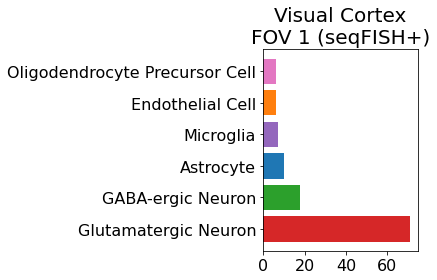

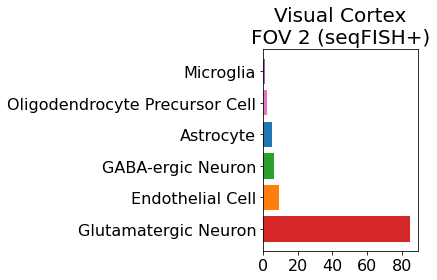

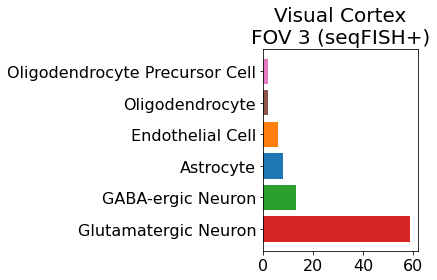

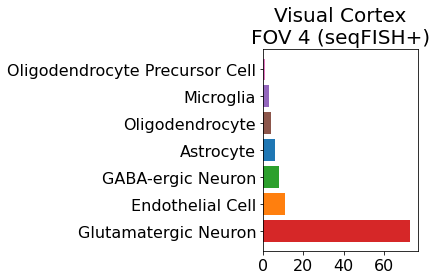

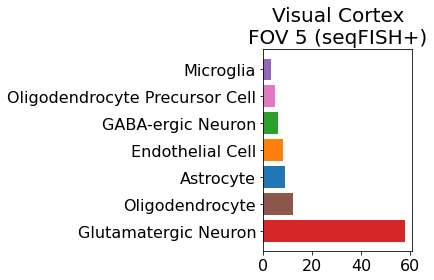

<Figure size 432x288 with 0 Axes>

In [7]:
for fov in range(5):
    df= spatial_metadata[spatial_metadata['Cell FOV'] == fov]["Cell type"].value_counts().reset_index()
    df['color'] = [cmap[c] for c in df['Cell type']]
    plt.barh(y=df['Cell type'], width=df['count'], color=df['color'])
    plt.title(f'Visual Cortex\nFOV {fov+1} (seqFISH+)', fontsize=20)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"results/seqFISH_fov_{fov}.png", dpi=200)
    plt.show(); plt.clf()

Separate spatial dataset. For each pair of cell types, divided cell pairs into close and distant groups based on physical distance. Calculated mutual information of the FISH expression among signaling pathway genes acrross the two groups of cell pairs. Bona fide signaling pathway genes should have higher MI of spatial expression in these cells than cells that are distant from each other.

## Convert Spatial to Human

In [8]:
human_to_mouse = pd.read_csv('data/HMD_HumanPhenotype.rpt', sep='\t', header=None)
mouse_to_human = defaultdict(list)
for row in human_to_mouse.iterrows():
    mouse_to_human[row[1][2]].append(row[1][0])

In [9]:
mouse_names = []
human_names = []

for gene in spatial_data.columns:
    for human_conv in mouse_to_human[gene]:
        mouse_names.append(gene)
        human_names.append(human_conv)

In [10]:
spatial_data = spatial_data[mouse_names]
spatial_data.columns = human_names
spatial_data = spatial_data.iloc[:, ~spatial_data.columns.duplicated()]

## Get pairs of astrocyte and endothelial cells that are close and distant 

In [11]:
mask = spatial_metadata['Cell type'].isin(['Astrocyte', 'Endothelial Cell'])
spatial_data = spatial_data[mask]
spatial_metadata = spatial_metadata[mask]

In [34]:
same_fov_pairs = []
for fov in range(5):
    spat_fov = spatial_metadata[spatial_metadata['Cell FOV'] == fov]
    endo = spat_fov[spat_fov['Cell type'] == 'Endothelial Cell'].index
    astro = spat_fov[spat_fov['Cell type'] == 'Astrocyte'].index
    for cell1 in endo:
        for cell2 in astro:
            same_fov_pairs.append((cell1, cell2))
same_fov_pairs = np.array(same_fov_pairs)

In [35]:
different_fov_pairs = []
for fov1 in range(5):
    for fov2 in range(5):
        if fov1 == fov2:
            continue
            
        spat_fov1 = spatial_metadata[spatial_metadata['Cell FOV'] == fov1]
        endo1 = spat_fov1[spat_fov1['Cell type'] == 'Endothelial Cell'].index
        astro1 = spat_fov1[spat_fov1['Cell type'] == 'Astrocyte'].index
       
        spat_fov2 = spatial_metadata[spatial_metadata['Cell FOV'] == fov2]
        endo2 = spat_fov2[spat_fov2['Cell type'] == 'Endothelial Cell'].index
        astro2 = spat_fov2[spat_fov2['Cell type'] == 'Astrocyte'].index
        
        for cell1 in endo1:
            for cell2 in astro2:
                different_fov_pairs.append((cell1, cell2))
different_fov_pairs = np.array(different_fov_pairs)

## Get signaling network genes & subset spatial data and network to intersected nodes

In [36]:
learned_network = pd.read_csv(f'results/Astrocyte_Endothelial Cell_15_q0.1_learned_graph.csv', index_col=0)

In [37]:
nodes = pd.read_csv(f'results/Astrocyte_Endothelial Cell_15_q0.1_node_df.csv', index_col=0)

In [38]:
intersection_nodes = list(set(spatial_data.columns).intersection(nodes.index))

In [39]:
other_genes = list(set(spatial_data.columns.values) - set(intersection_nodes))
np.random.shuffle(other_genes)

random_pairs = []
for gene1 in other_genes[:58]:
    for gene2 in other_genes[58:58+27]:
        random_pairs.append((gene1, gene2))

In [41]:
learned_network = learned_network[(learned_network['0'].isin(intersection_nodes)) & (learned_network['1'].isin(intersection_nodes))]
nodes = nodes.loc[intersection_nodes]

## Calculate pairwise MI between pairs of genes (one from each cell type and are connected in the predicted signaling pathways) across individual cells

In [42]:
learned_network['0_label'] = list(nodes.loc[learned_network['0']]['node_label'].values)
learned_network['1_label'] = list(nodes.loc[learned_network['1']]['node_label'].values)

In [43]:
astrocyte_genes = nodes[nodes['node_label'] == 'Astrocyte'].index
endothelial_genes = nodes[nodes['node_label'] == 'Endothelial Cell'].index

In [44]:
endo_astro_pairs = []
for gene1 in endothelial_genes:
    for gene2 in astrocyte_genes:
        endo_astro_pairs.append((gene1, gene2))

In [46]:
same_fov_MI = []
for pair in endo_astro_pairs:
    same_fov_MI.append(scprep.stats.mutual_information(spatial_data.loc[same_fov_pairs[:, 0], pair[0]],
                                spatial_data.loc[same_fov_pairs[:, 1], pair[1]]))

In [47]:
different_fov_MI = []
for pair in endo_astro_pairs:
    different_fov_MI.append(scprep.stats.mutual_information(spatial_data.loc[different_fov_pairs[:, 0], pair[0]],
                                spatial_data.loc[different_fov_pairs[:, 1], pair[1]]))

In [49]:
same_fov_MI_random = []
for pair in random_pairs:
    same_fov_MI_random.append(scprep.stats.mutual_information(spatial_data.loc[same_fov_pairs[:, 0], pair[0]],
                                spatial_data.loc[same_fov_pairs[:, 1], pair[1]]))

In [50]:
different_fov_MI_random = []
for pair in random_pairs:
    different_fov_MI_random.append(scprep.stats.mutual_information(spatial_data.loc[different_fov_pairs[:, 0], pair[0]],
                                spatial_data.loc[different_fov_pairs[:, 1], pair[1]]))

In [83]:
sns.set(font_scale=1.4, style='white')

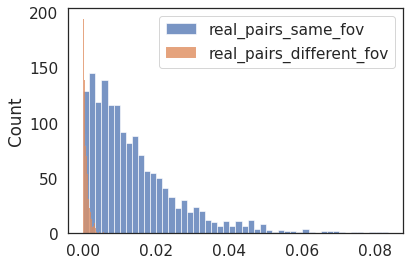

In [86]:
fig, ax =plt.subplots()
sns.histplot(same_fov_MI, ax=ax, label='real_pairs_same_fov', bins=50)
sns.histplot(different_fov_MI, ax=ax, label='real_pairs_different_fov', bins=50)
plt.legend()
plt.tight_layout()
fig.savefig('results/same_vs_different_fov.png', dpi=200)

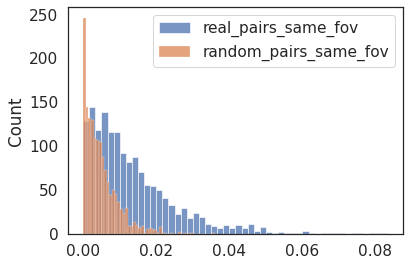

In [88]:
fig, ax =plt.subplots()
sns.histplot(same_fov_MI, ax=ax, label='real_pairs_same_fov', bins=50)
sns.histplot(same_fov_MI_random, ax=ax, label='random_pairs_same_fov', bins=50)
plt.legend()
plt.tight_layout()
fig.savefig('results/real_pairs_vs_random_pairs.png', dpi=200)

In [73]:
# our genes have higher MI in same FOV than in different FOV
scipy.stats.kstest(different_fov_MI, same_fov_MI, alternative='greater')

KstestResult(statistic=0.8314176245210728, pvalue=0.0, statistic_location=0.0022259063684974406, statistic_sign=1)

In [75]:
# within same FOV, our pairs have higher MI than random pairs
scipy.stats.kstest(same_fov_MI_random, same_fov_MI, alternative='greater')

KstestResult(statistic=0.4074074074074074, pvalue=6.372667710606944e-117, statistic_location=0.008146441465572245, statistic_sign=1)